In [1]:
import pandas as pd          
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.concat(map(pd.read_csv, ['tennis_atp/atp_matches_2018.csv','tennis_atp/atp_matches_2019.csv', 'tennis_atp/atp_matches_2020.csv','tennis_atp/atp_matches_2021.csv','tennis_atp/atp_matches_2022.csv','tennis_atp/atp_matches_2023.csv','tennis_atp/atp_matches_2024.csv']))

In [3]:
# Remove identifying data
# Find a way to include tourney_level and score
df = df.drop(columns=['winner_id', 'winner_name', 'winner_ioc', 
                      'loser_id', 'loser_name', 'loser_ioc', 
                      'tourney_id', 'tourney_name', 'tourney_level', 
                      'tourney_date', 'match_num', 'winner_seed', 
                      'winner_entry', 'loser_seed', 'loser_entry','score', 'draw_size', 'best_of', 'round'])

In [4]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates no action needed
print(df.duplicated().sum())

# Drop any rows with nulls in them
df = df.dropna()

# Check 
row_count = len(df)
print(row_count)

surface                 53
winner_hand              0
winner_ht               79
winner_age               3
loser_hand               1
loser_ht               227
loser_age                3
minutes               1033
w_ace                  694
w_df                   694
w_svpt                 694
w_1stIn                694
w_1stWon               694
w_2ndWon               694
w_SvGms                694
w_bpSaved              694
w_bpFaced              694
l_ace                  694
l_df                   694
l_svpt                 694
l_1stIn                694
l_1stWon               694
l_2ndWon               694
l_SvGms                694
l_bpSaved              694
l_bpFaced              694
winner_rank             79
winner_rank_points      79
loser_rank             222
loser_rank_points      222
dtype: int64
2
17547


In [5]:
winner_encoder = LabelEncoder()
loser_encoder = LabelEncoder()
surface_encoder = LabelEncoder()
round_encoder = LabelEncoder()


df['winner_hand'] = winner_encoder.fit_transform(df['winner_hand'])
df['loser_hand'] = loser_encoder.fit_transform(df['loser_hand'])
df['surface'] = surface_encoder.fit_transform(df['surface'])
# df['round'] = round_encoder.fit_transform(df['round'])

In [6]:
# Rename values to not be associated with winner.
df = df.rename(columns={
    'winner_age': 'p1_age',
    'winner_ht': 'p1_ht',
    'winner_hand': 'p1_hand',
    'winner_rank': 'p1_rank',
    'winner_rank_points': 'p1_rank_points',
    'loser_age': 'p2_age',
    'loser_ht': 'p2_ht',
    'loser_hand': 'p2_hand',
    'loser_rank': 'p2_rank',
    'loser_rank_points': 'p2_rank_points',
    
    'w_ace': 'p1_ace',
    'w_df': 'p1_df',
    'w_svpt': 'p1_svpt',
    'w_1stIn': 'p1_1stIn',
    'w_1stWon': 'p1_1stWon',
    'w_2ndWon': 'p1_2ndWon',
    'w_SvGms': 'p1_SvGms',
    'w_bpSaved': 'p1_bpSaved',
    'w_bpFaced': 'p1_bpFaced',

    'l_ace': 'p2_ace',
    'l_df': 'p2_df',
    'l_svpt': 'p2_svpt',
    'l_1stIn': 'p2_1stIn',
    'l_1stWon': 'p2_1stWon',
    'l_2ndWon': 'p2_2ndWon',
    'l_SvGms': 'p2_SvGms',
    'l_bpSaved': 'p2_bpSaved',
    'l_bpFaced': 'p2_bpFaced'
})

swap_mask = np.random.rand(len(df)) > 0.5

swap_cols = [
    'age', 'ht', 'hand', 'rank', 'rank_points',
    'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced'
]

for col in swap_cols:
    temp = df.loc[swap_mask, f'p1_{col}'].copy()
    df.loc[swap_mask, f'p1_{col}'] = df.loc[swap_mask, f'p2_{col}']
    df.loc[swap_mask, f'p2_{col}'] = temp

df['winner'] = np.where(swap_mask, 1, 0)

print(df['winner'].value_counts())

winner
0    8816
1    8731
Name: count, dtype: int64


In [7]:
# Display the first and last few rows of the dataset.
display(df.head())
display(df.tail())

# Display the info of the dataset.
display(df.info())

# Display summary statistics of the dataset.
display(df.describe())

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
0,2,1,188.0,30.6,1,185.0,25.6,123.0,10.0,3.0,...,39.0,20.0,13.0,8.0,9.0,52.0,909.0,47.0,1010.0,1
1,2,1,183.0,23.7,1,188.0,21.2,90.0,3.0,5.0,...,25.0,14.0,9.0,4.0,5.0,94.0,593.0,54.0,890.0,1
2,2,1,185.0,31.3,1,175.0,25.6,145.0,7.0,0.0,...,37.0,29.0,15.0,10.0,16.0,63.0,809.0,30.0,1391.0,0
3,2,1,183.0,18.8,1,188.0,28.0,104.0,9.0,3.0,...,33.0,17.0,11.0,4.0,6.0,208.0,245.0,44.0,1055.0,0
4,2,0,193.0,27.2,1,188.0,19.9,69.0,4.0,0.0,...,32.0,11.0,10.0,3.0,3.0,68.0,755.0,175.0,299.0,1


,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
3064,2,1,183.0,28.2,1,175.0,25.0,87.0,2.0,1.0,...,25.0,11.0,9.0,2.0,3.0,819.0,24.0,569.0,64.0,1
3066,2,1,178.0,31.0,1,188.0,28.8,65.0,4.0,2.0,...,17.0,9.0,8.0,2.0,5.0,279.0,205.0,900.0,18.0,0
3068,0,1,188.0,21.8,0,185.0,23.9,137.0,0.0,5.0,...,31.0,13.0,12.0,5.0,9.0,740.0,34.0,616.0,55.0,1
3070,0,1,175.0,34.2,0,185.0,23.9,95.0,2.0,1.0,...,33.0,6.0,8.0,6.0,11.0,136.0,489.0,616.0,55.0,0
3074,2,1,185.0,27.3,1,175.0,26.9,159.0,5.0,3.0,...,41.0,13.0,14.0,2.0,5.0,416.0,109.0,554.0,67.0,1


<class 'pandas.core.frame.DataFrame'>
Index: 17547 entries, 0 to 3074
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   surface         17547 non-null  int64  
 1   p1_hand         17547 non-null  int64  
 2   p1_ht           17547 non-null  float64
 3   p1_age          17547 non-null  float64
 4   p2_hand         17547 non-null  int64  
 5   p2_ht           17547 non-null  float64
 6   p2_age          17547 non-null  float64
 7   minutes         17547 non-null  float64
 8   p1_ace          17547 non-null  float64
 9   p1_df           17547 non-null  float64
 10  p1_svpt         17547 non-null  float64
 11  p1_1stIn        17547 non-null  float64
 12  p1_1stWon       17547 non-null  float64
 13  p1_2ndWon       17547 non-null  float64
 14  p1_SvGms        17547 non-null  float64
 15  p1_bpSaved      17547 non-null  float64
 16  p1_bpFaced      17547 non-null  float64
 17  p2_ace          17547 non-null  float

None

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
count,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,...,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000
mean,1.304383,0.859520,187.251667,27.135009,0.861743,187.205790,27.140075,115.207215,6.358181,2.943637,...,35.937026,15.475067,12.621474,4.130507,6.741608,79.247165,1524.161737,79.784123,1533.173648,0.497578
std,0.893933,0.347494,7.199185,4.565813,0.345180,6.992049,4.578931,42.268962,5.496140,2.452783,...,14.139180,6.822169,4.210127,3.242271,4.423678,108.967635,1717.743594,107.232011,1730.560250,0.500008
min,0.000000,0.000000,15.000000,16.700000,0.000000,71.000000,16.400000,5.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,1.000000,183.000000,23.600000,1.000000,183.000000,23.600000,83.000000,2.000000,1.000000,...,26.000000,11.000000,10.000000,2.000000,3.000000,25.000000,648.000000,26.000000,640.000000,0.000000
50%,2.000000,1.000000,188.000000,26.800000,1.000000,188.000000,26.800000,108.000000,5.000000,2.000000,...,34.000000,14.000000,12.000000,4.000000,6.000000,55.000000,950.000000,55.000000,949.000000,0.000000
75%,2.000000,1.000000,193.000000,30.200000,1.000000,193.000000,30.300000,139.000000,9.000000,4.000000,...,44.000000,19.000000,15.000000,6.000000,9.000000,94.000000,1640.000000,94.000000,1628.500000,1.000000
max,2.000000,1.000000,211.000000,42.300000,1.000000,211.000000,42.500000,396.000000,64.000000,23.000000,...,166.000000,56.000000,49.000000,27.000000,38.000000,2146.000000,12415.000000,1921.000000,12415.000000,1.000000


In [8]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates
print(df.duplicated().sum())

surface           0
p1_hand           0
p1_ht             0
p1_age            0
p2_hand           0
p2_ht             0
p2_age            0
minutes           0
p1_ace            0
p1_df             0
p1_svpt           0
p1_1stIn          0
p1_1stWon         0
p1_2ndWon         0
p1_SvGms          0
p1_bpSaved        0
p1_bpFaced        0
p2_ace            0
p2_df             0
p2_svpt           0
p2_1stIn          0
p2_1stWon         0
p2_2ndWon         0
p2_SvGms          0
p2_bpSaved        0
p2_bpFaced        0
p1_rank           0
p1_rank_points    0
p2_rank           0
p2_rank_points    0
winner            0
dtype: int64
0


In [9]:
# Drop any rows with nulls in them
df = df.dropna()

# Check 
row_count = len(df)
print(row_count)

17547


In [10]:
scaler = StandardScaler()
y = df['winner'].values

X = df.drop(columns=['winner'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

display(y)
display(X)

array([1, 1, 0, ..., 1, 0, 1], shape=(17547,))

array([[ 0.77817611,  0.40427696,  0.10394988, ..., -0.35813219,
        -0.30573946, -0.30232323],
       [ 0.77817611,  0.40427696, -0.59059301, ..., -0.54209969,
        -0.24045858, -0.37166691],
       [ 0.77817611,  0.40427696, -0.31277585, ..., -0.41634975,
        -0.46427873, -0.08215704],
       ...,
       [-1.45919178,  0.40427696,  0.10394988, ..., -0.86753588,
         5.00066309, -0.85418336],
       [-1.45919178,  0.40427696, -1.70186163, ..., -0.60264596,
         5.00066309, -0.85418336],
       [ 0.77817611,  0.40427696, -0.31277585, ..., -0.82387271,
         4.42246105, -0.84724899]], shape=(17547, 30))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
display(y_train)

array([1, 0, 1, ..., 1, 0, 1], shape=(14037,))

Accuracy: 0.9467236467236467
Precision: 0.948821161587119
Recall: 0.9439359267734554
F1 Score: 0.9463722397476341
(14037, 30)


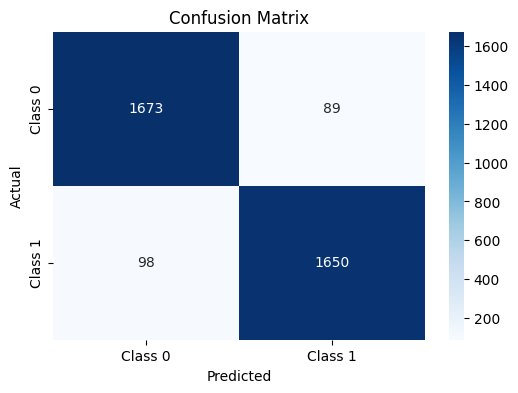

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

precision = precision_score(y_test, y_pred, average='binary')
print(f"Precision: {precision}")

recall = recall_score(y_test, y_pred, average='binary')
print(f"Recall: {recall}")

f1 = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score: {f1}")

print(X_train.shape)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.7854700854700855
Precision: 0.948821161587119
Recall: 0.9439359267734554
F1 Score: 0.9463722397476341
(14037, 30)


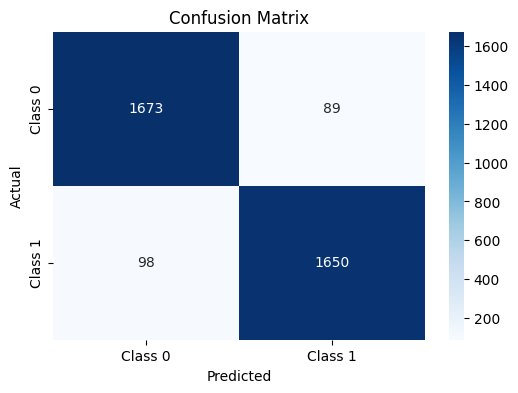

In [13]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X, y)
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

precision = precision_score(y_test, y_pred, average='binary')
print(f"Precision: {precision}")

recall = recall_score(y_test, y_pred, average='binary')
print(f"Recall: {recall}")

f1 = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score: {f1}")

print(X_train.shape)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.8678062678062678
Precision: 0.8719582850521437
Recall: 0.8609839816933639
F1 Score: 0.8664363845710996


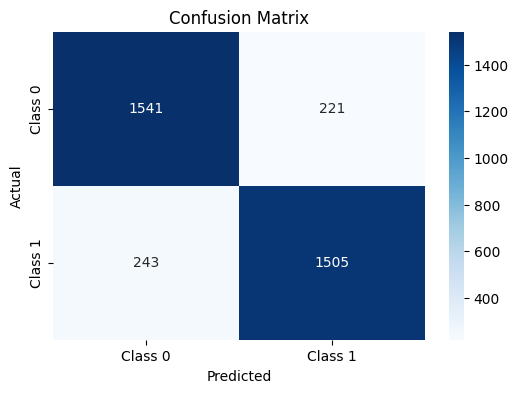

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,max_depth=10, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

precision = precision_score(y_test, y_pred, average='binary')
print(f"Precision: {precision}")

recall = recall_score(y_test, y_pred, average='binary')
print(f"Recall: {recall}")

f1 = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score: {f1}")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted');
plt.ylabel('Actual');